Import libraries

In [15]:
import os
import time

import torch
import numpy as np

import torch.optim as optim
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

from utils import config
from utils.dataset import GraphDataset, GraphData, get_sequential_edge_index
from vectornet.vectornet import VectornetGNN

import matplotlib.pyplot as plt
from utils.data_utils import draw_trajectory, create_ego_raster, create_agents_raster, create_map_raster, decoding_features, increment_to_trajectories

Use training set to test the output, as well as the plot function

In [16]:
# Set seed
np.random.seed(config.SEED)
torch.manual_seed(config.SEED)

# Get validation set
validate_data = GraphDataset(config.TRAIN_PATH)

# Load validation data
validate_loader = DataLoader(
    validate_data,
    batch_size=1
)

# Create predictor
device = device = torch.device(
    'cuda:0' if torch.cuda.is_available() else 'cpu'
)

model = VectornetGNN(
    in_channels=config.IN_CHANNELS,
    out_channels=config.OUT_CHANNELS,
).to(device)

model.load_state_dict(
    torch.load(config.WEIGHT_PATH + '/model_epoch_050.pth')
)

<All keys matched successfully>

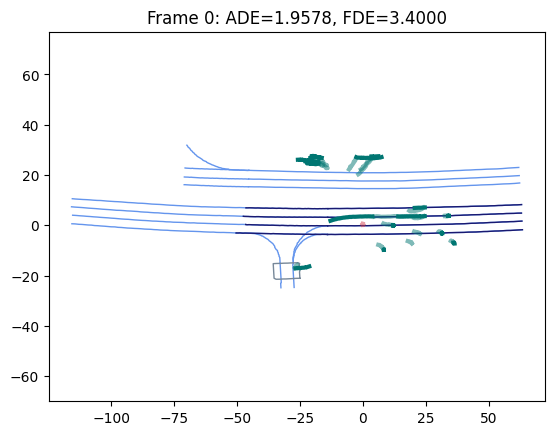

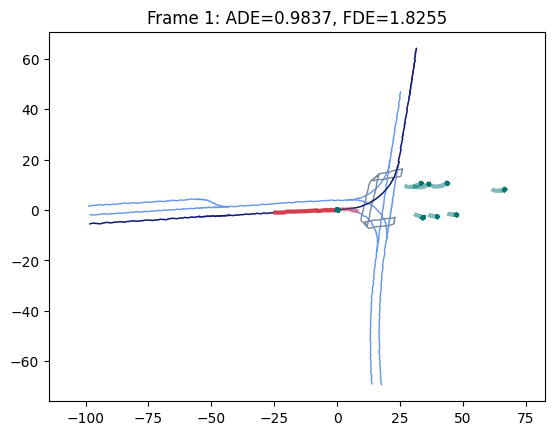

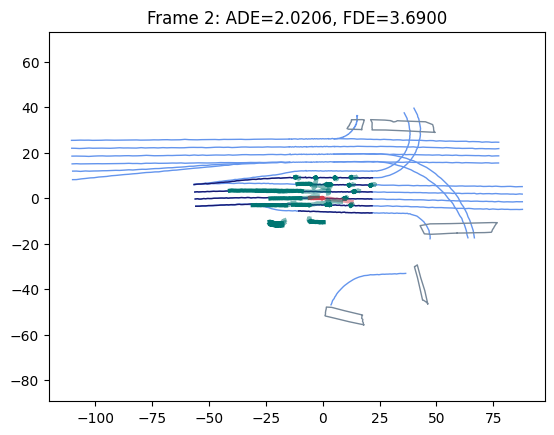

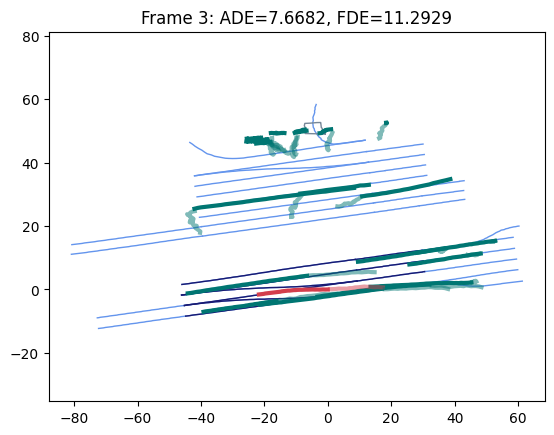

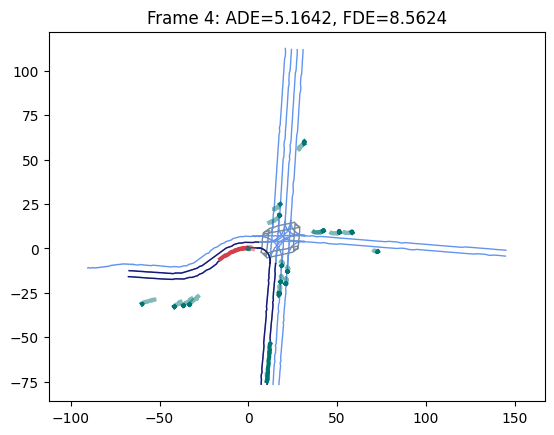

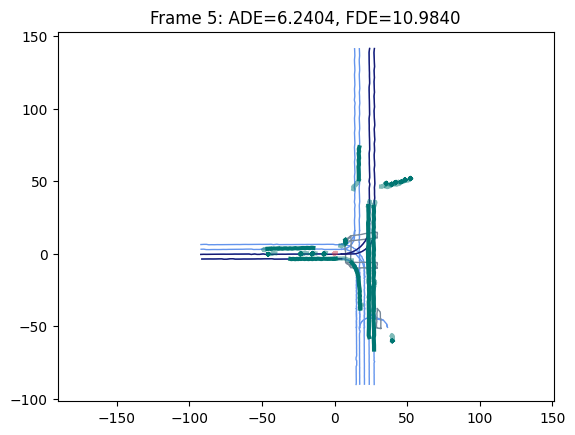

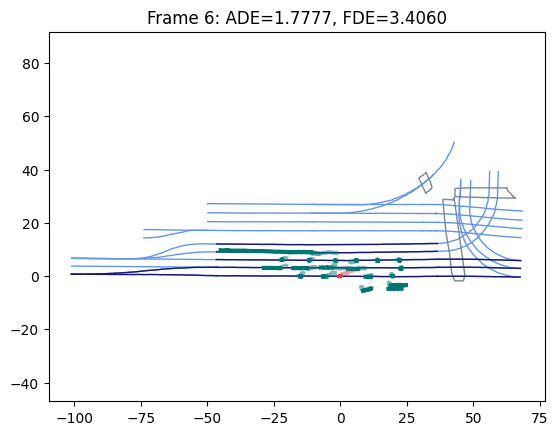

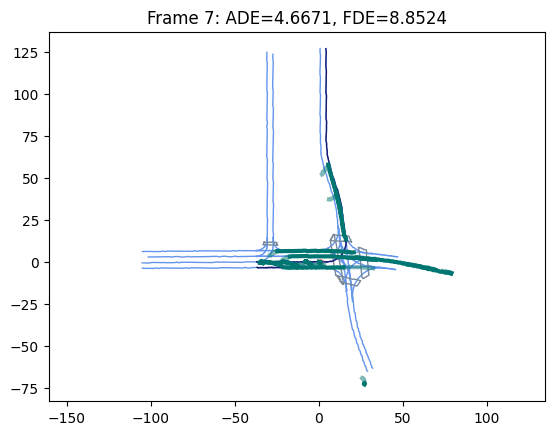

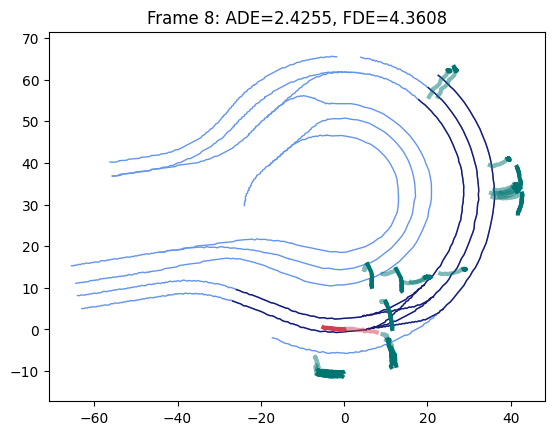

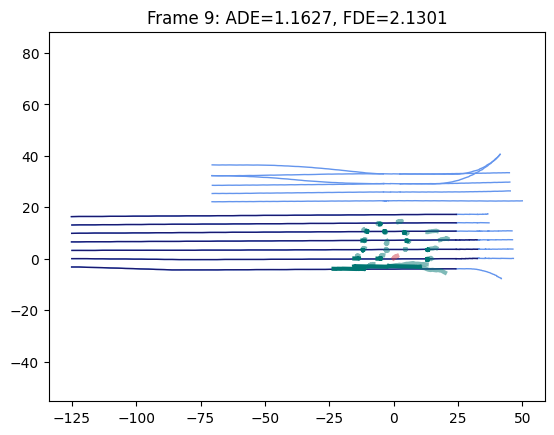

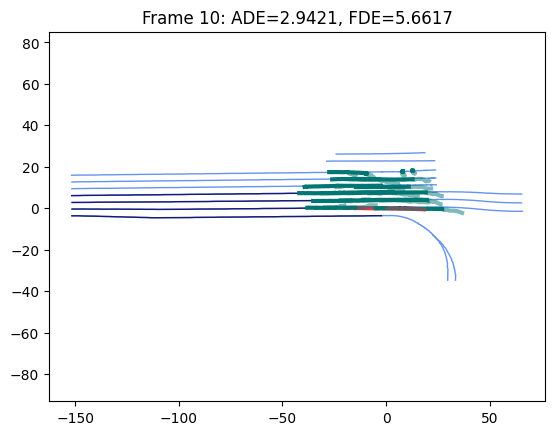

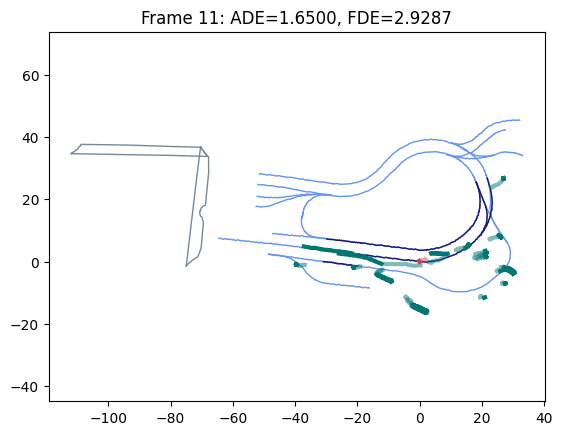

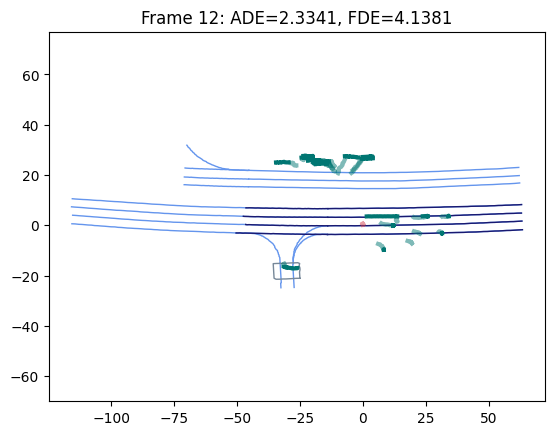

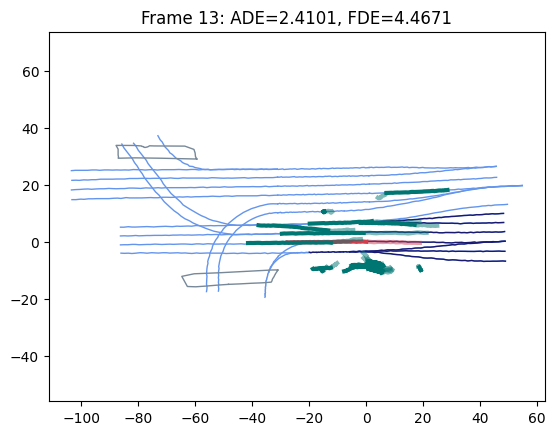

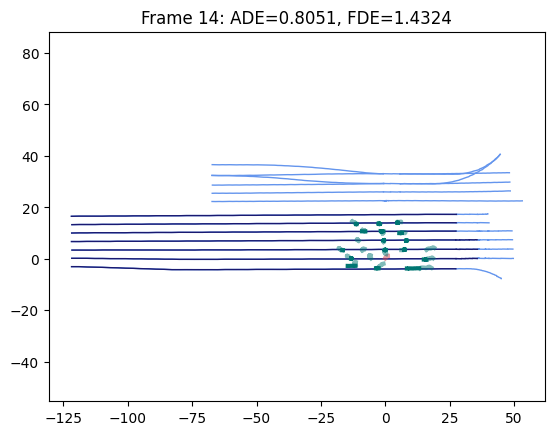

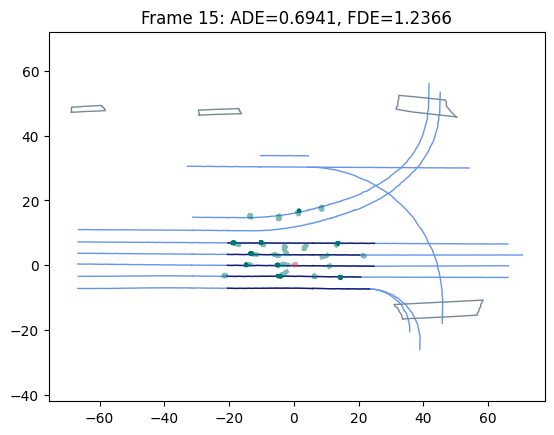

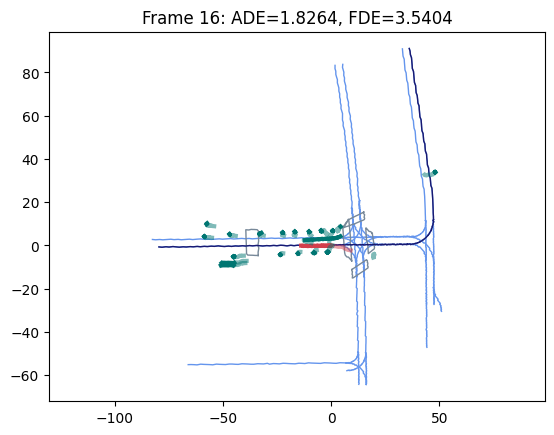

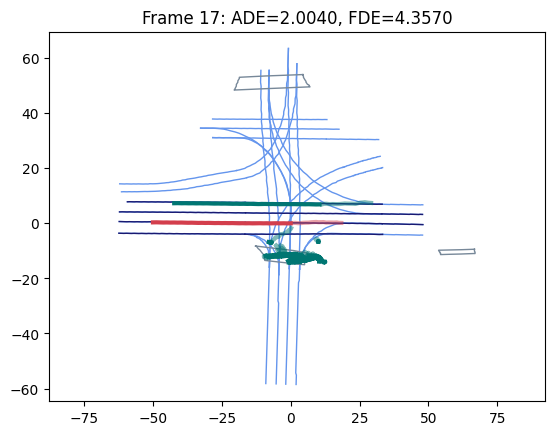

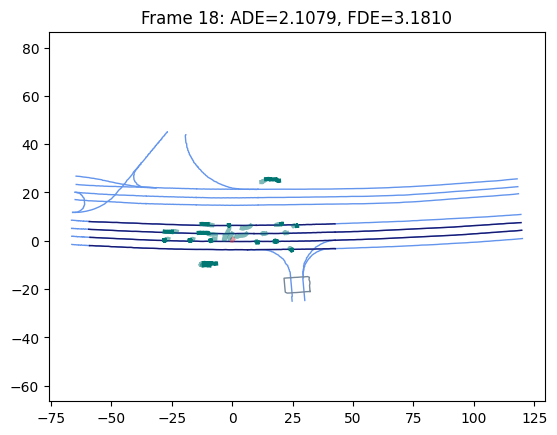

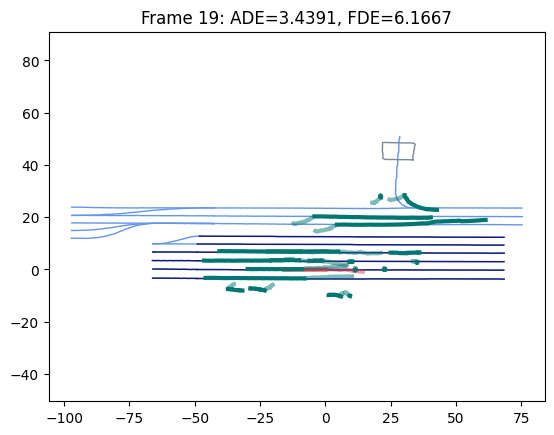

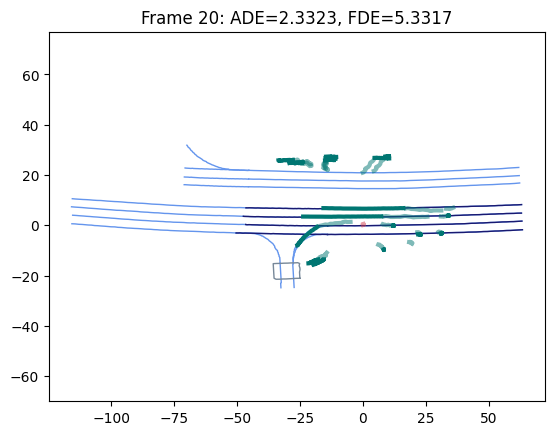

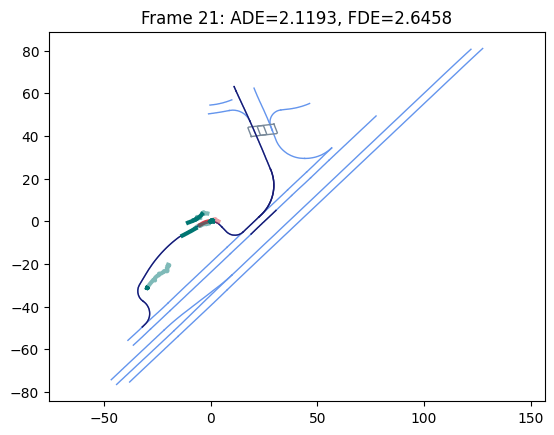

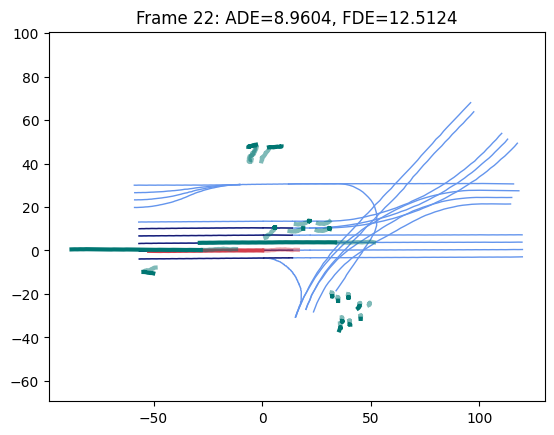

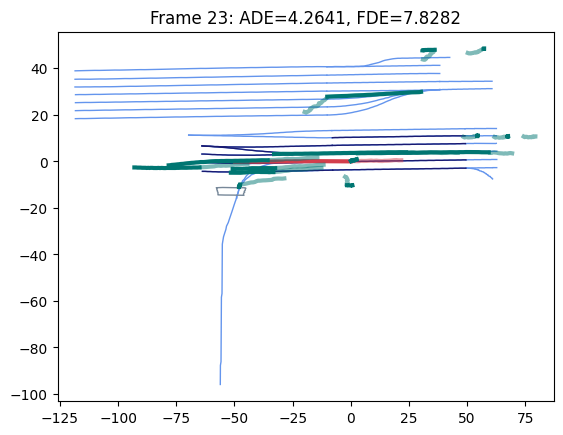

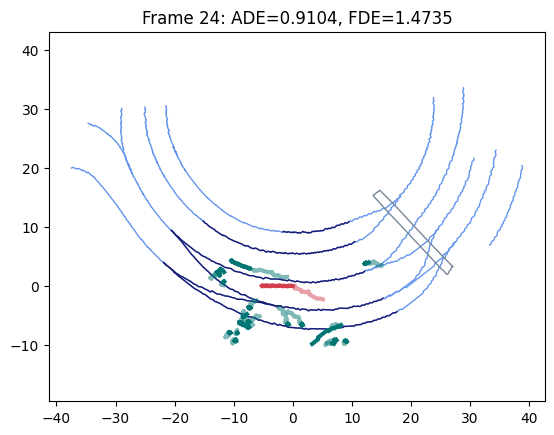

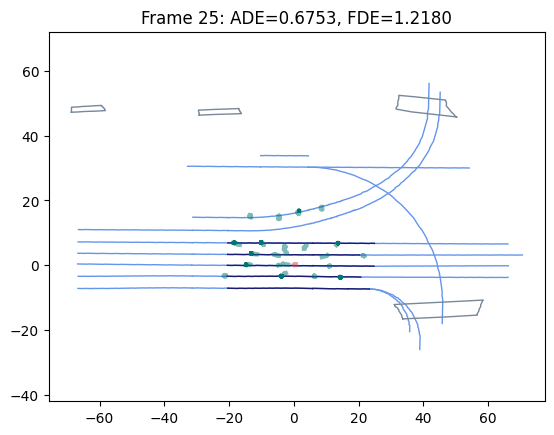

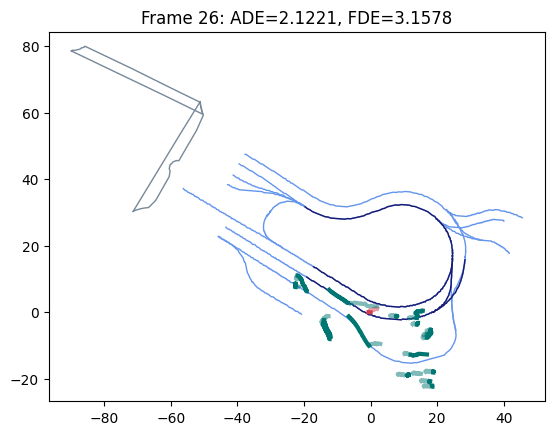

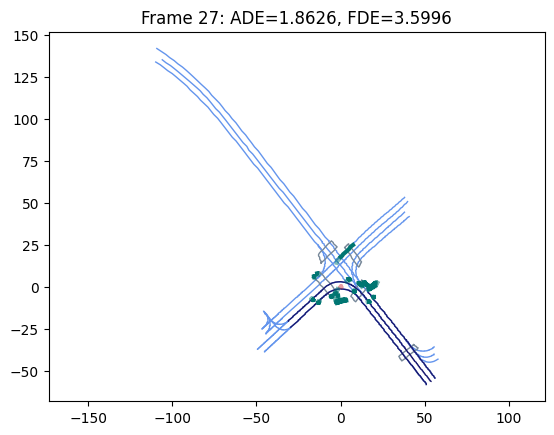

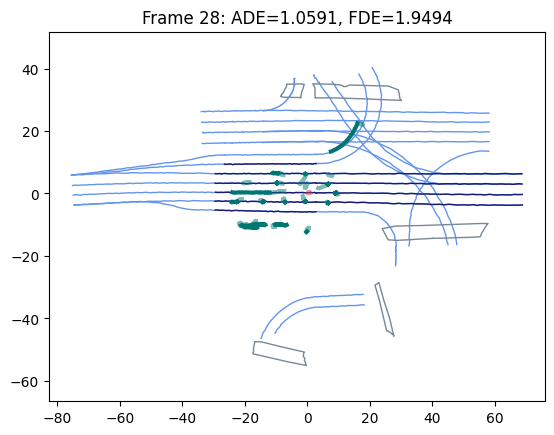

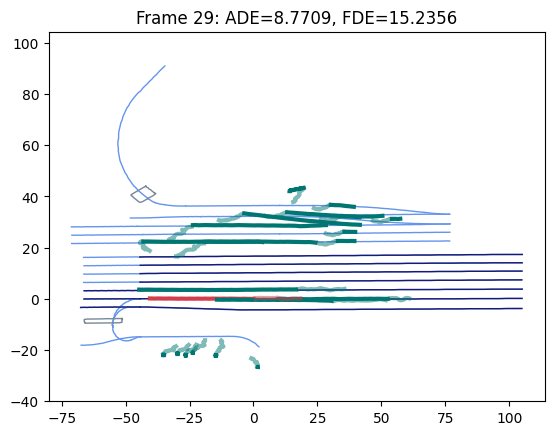

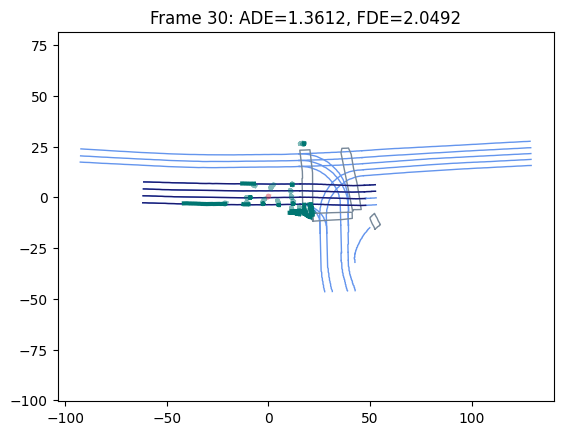

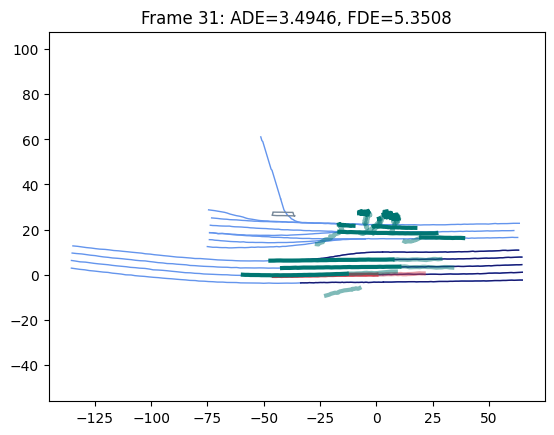

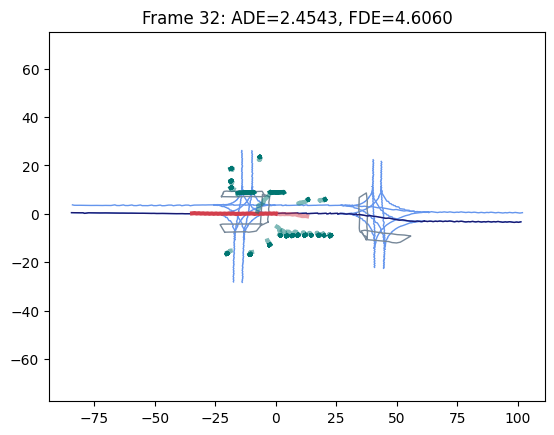

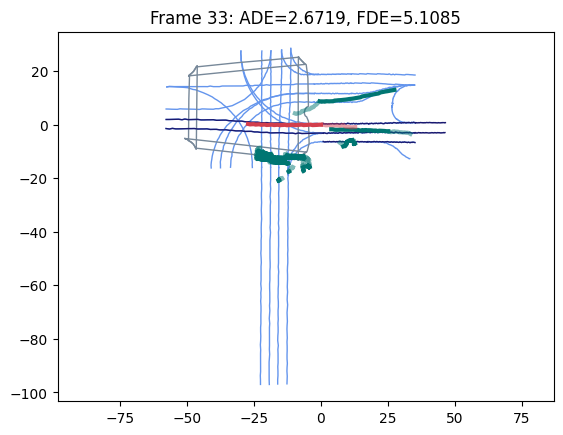

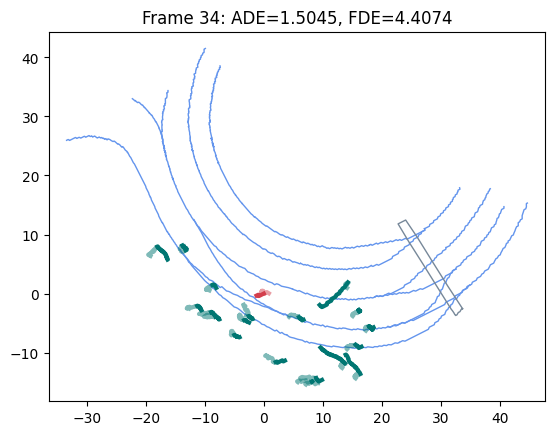

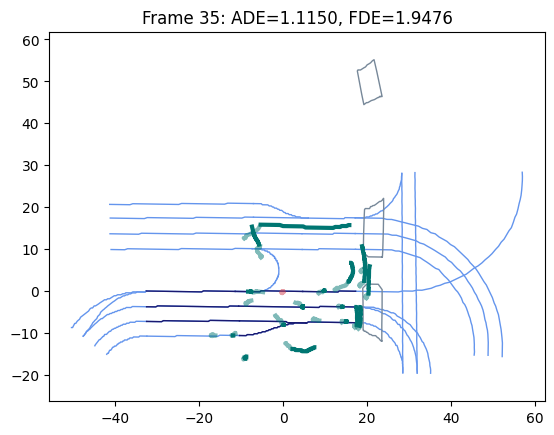

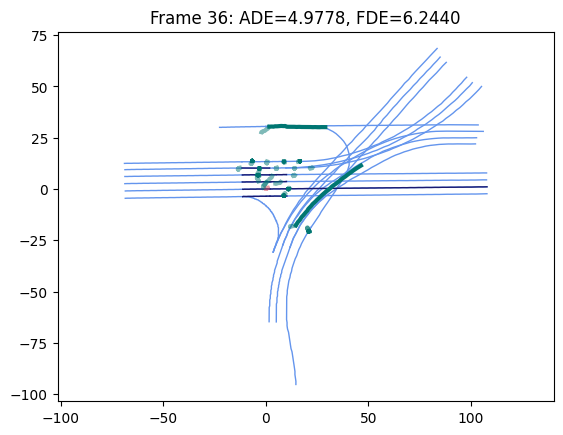

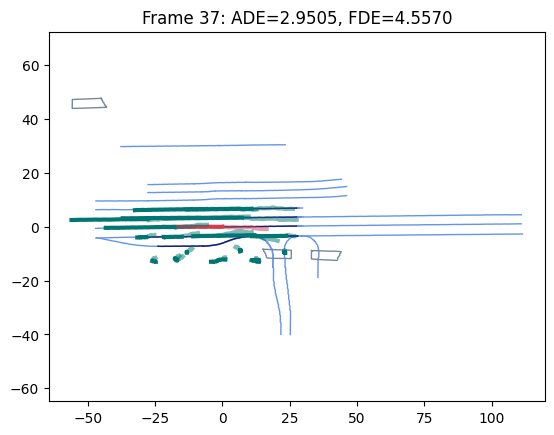

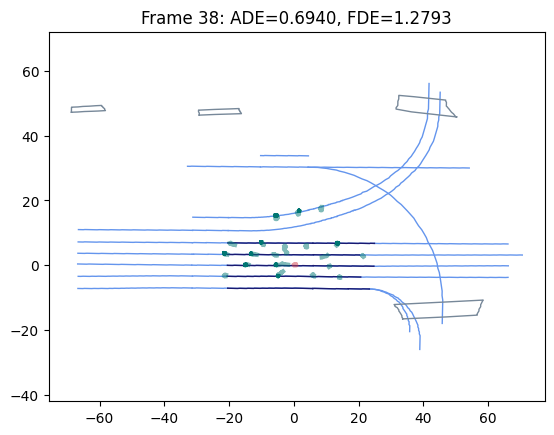

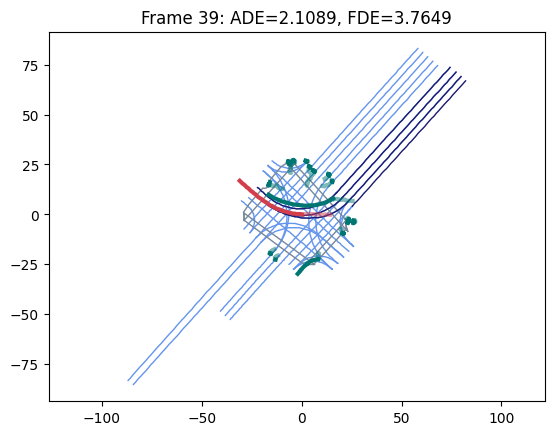

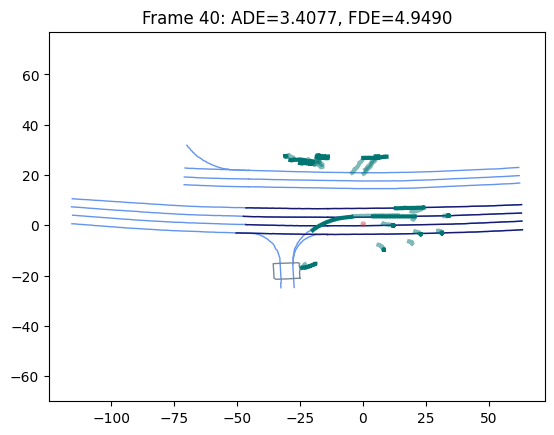

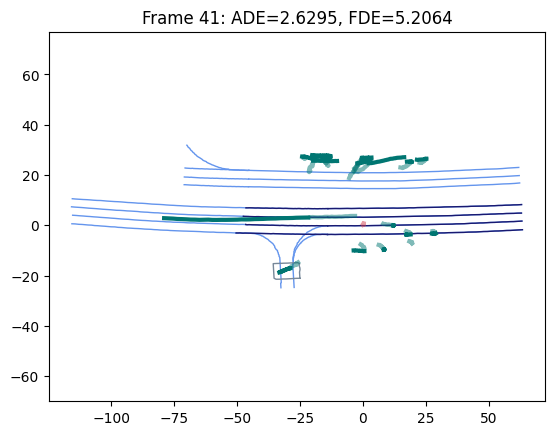

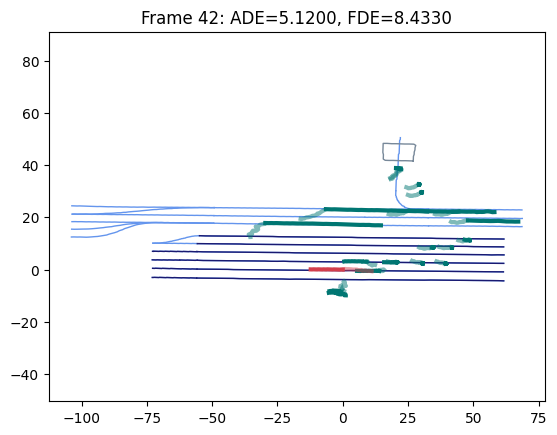

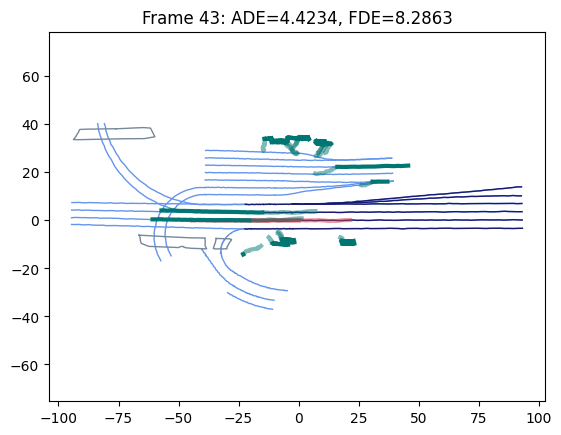

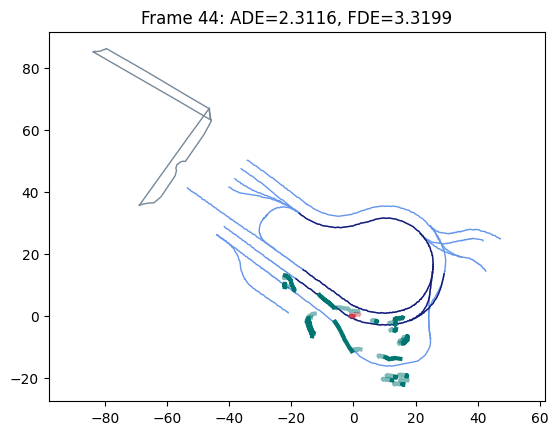

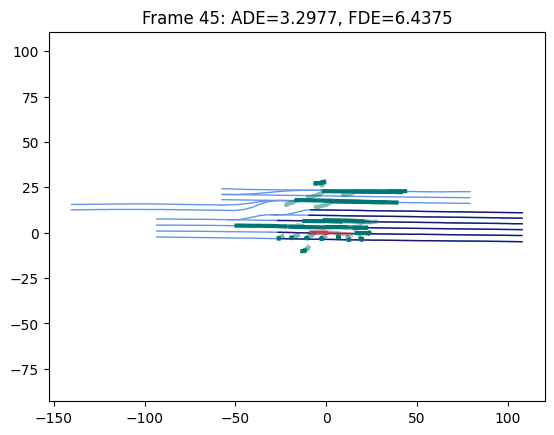

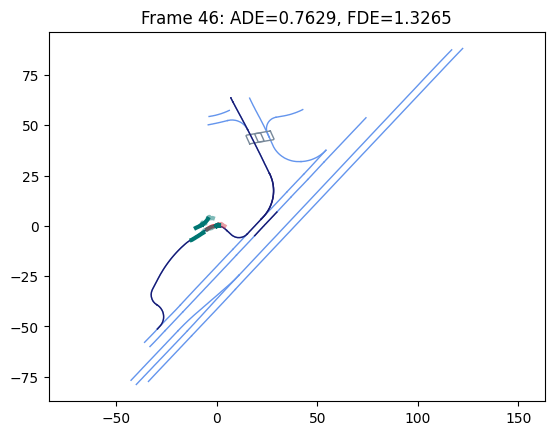

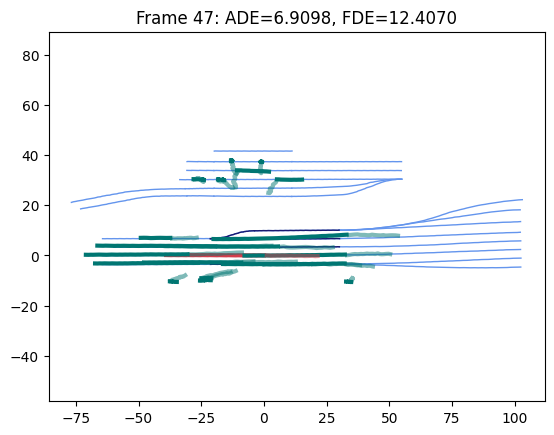

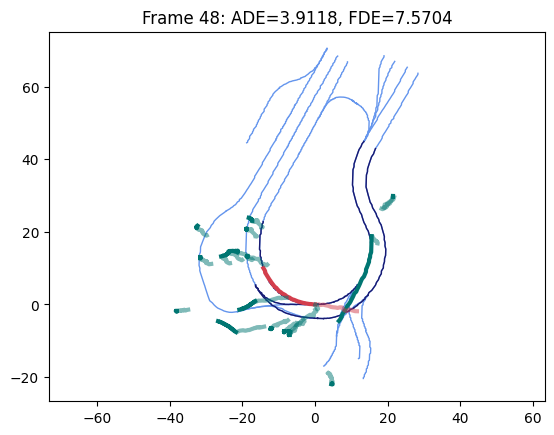

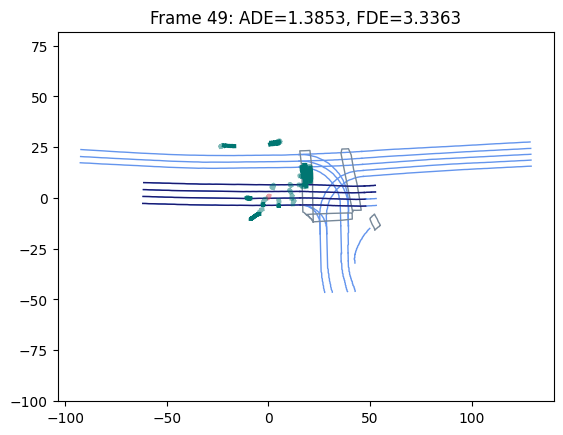

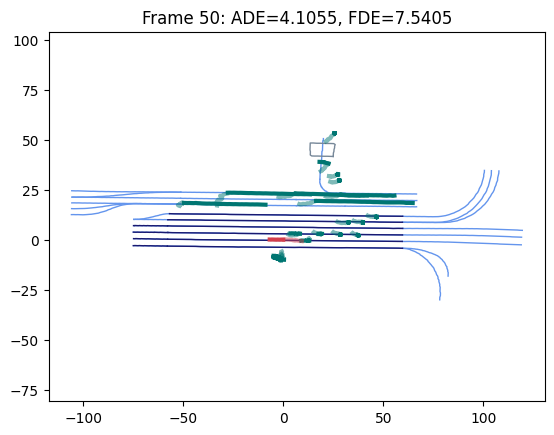

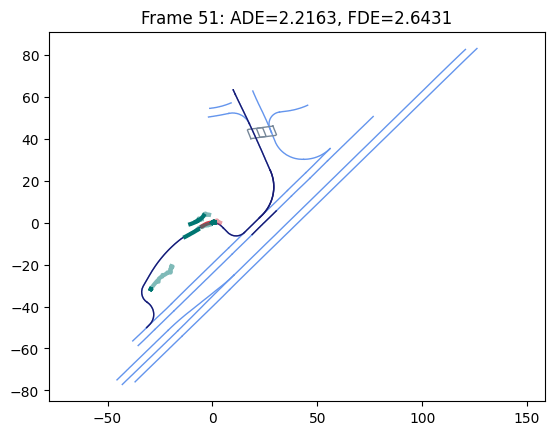

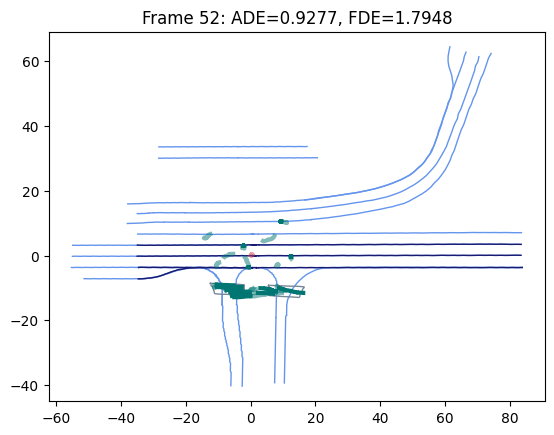

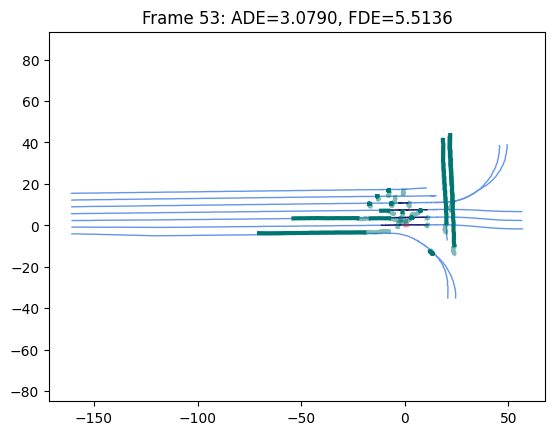

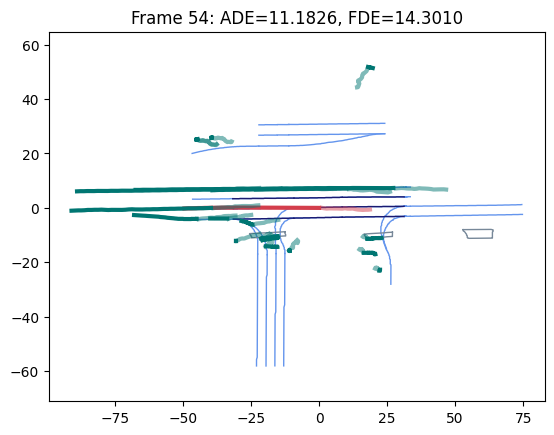

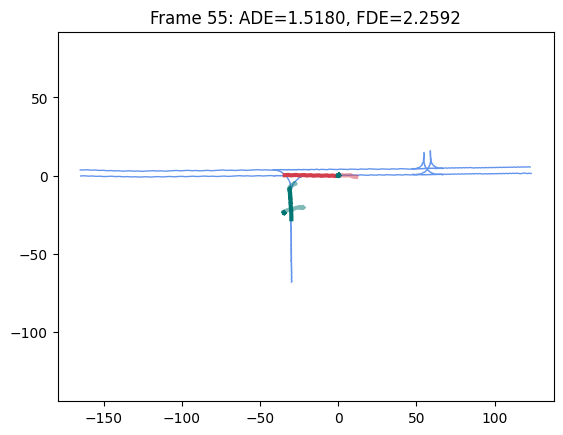

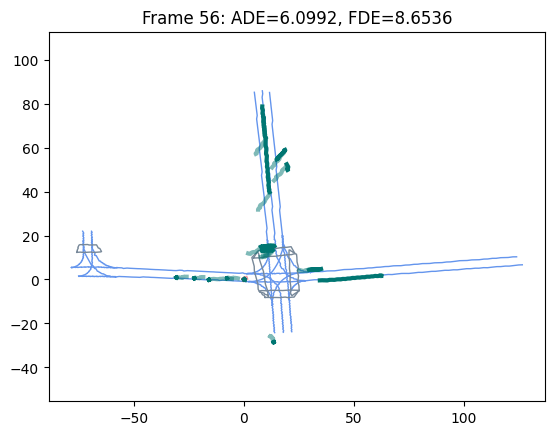

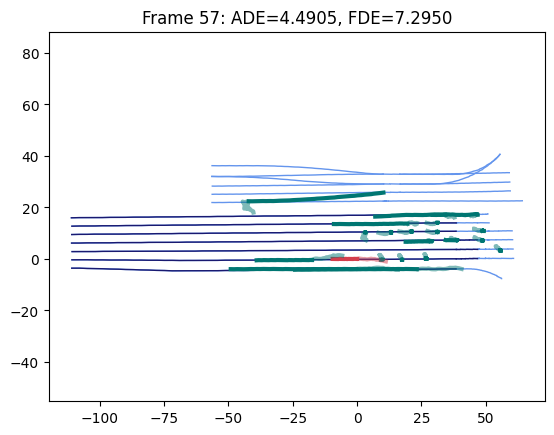

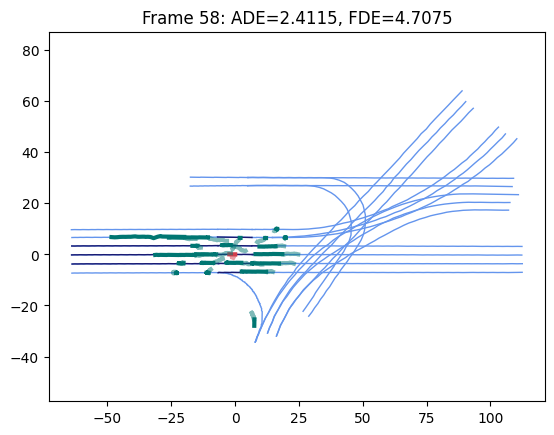

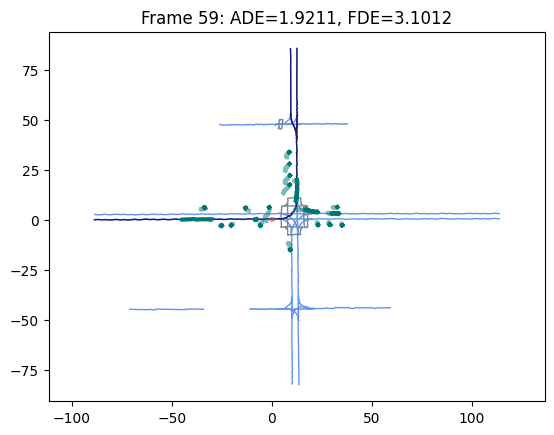

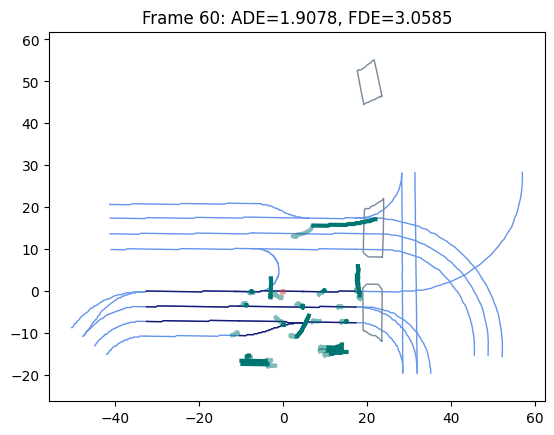

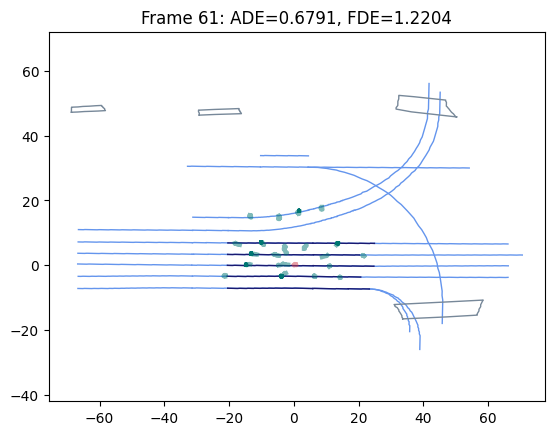

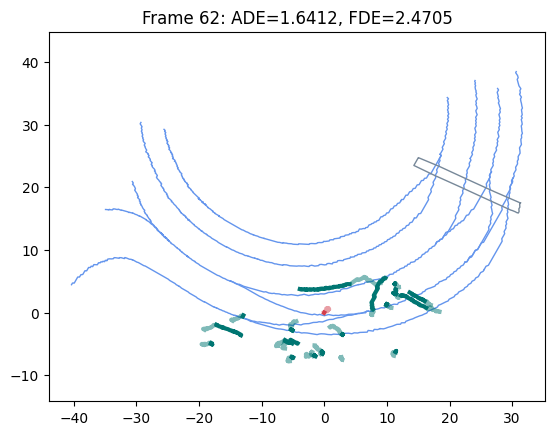

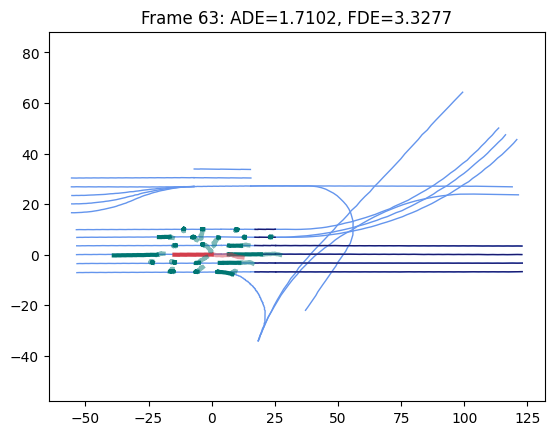

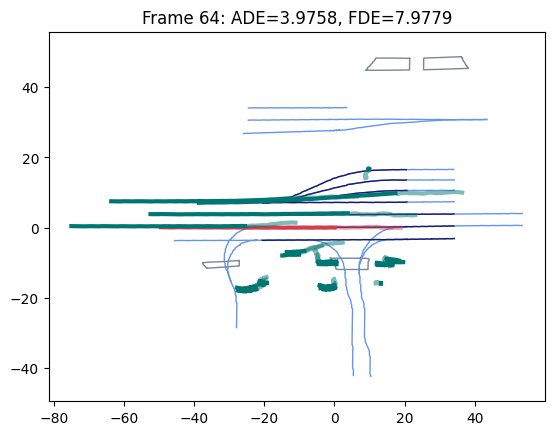

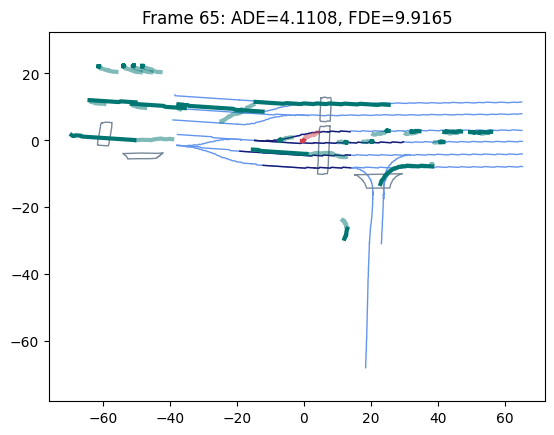

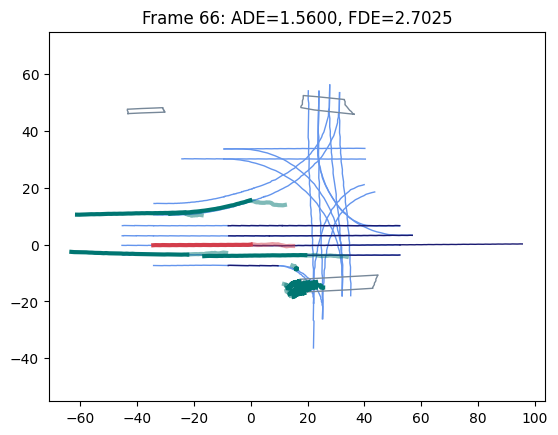

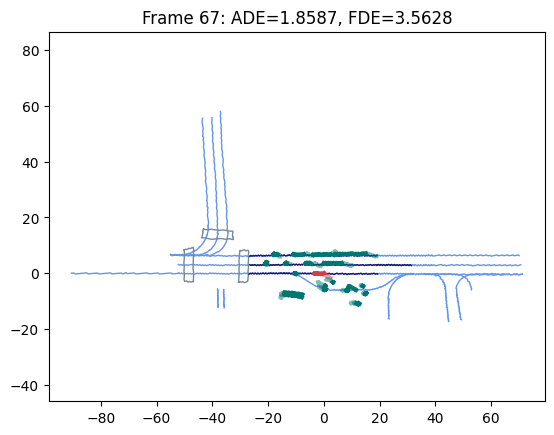

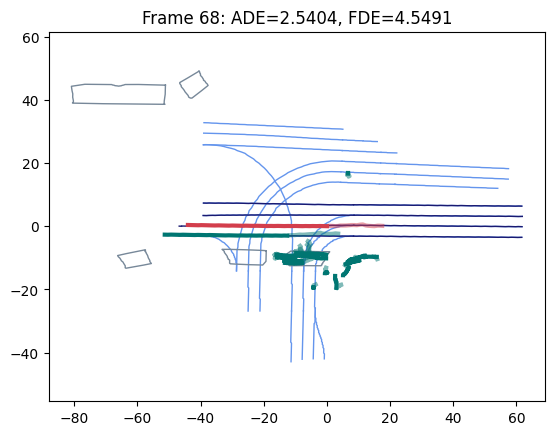

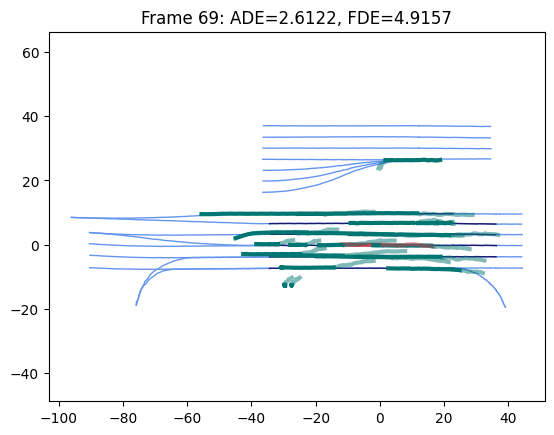

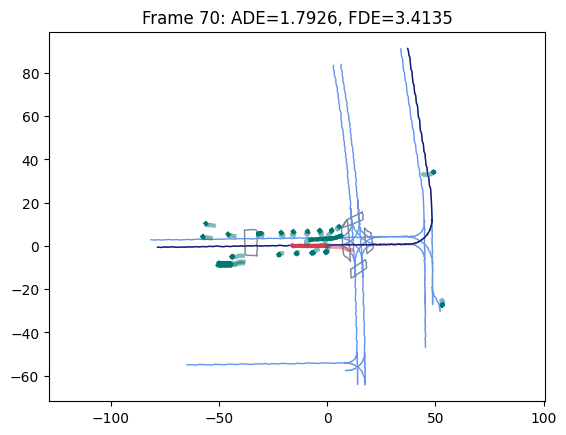

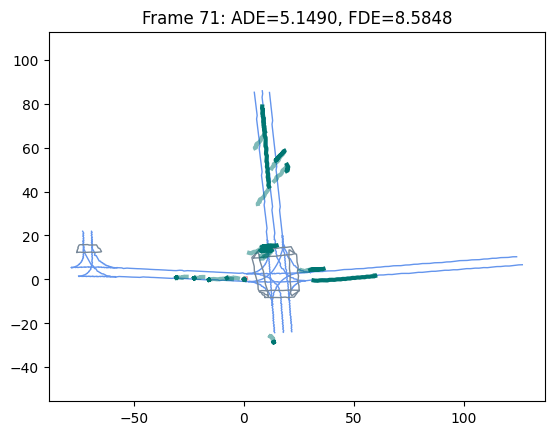

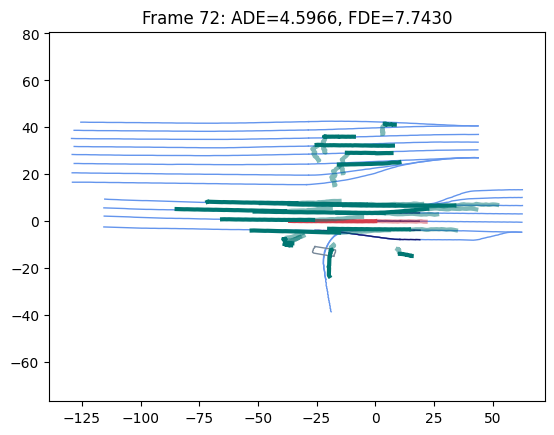

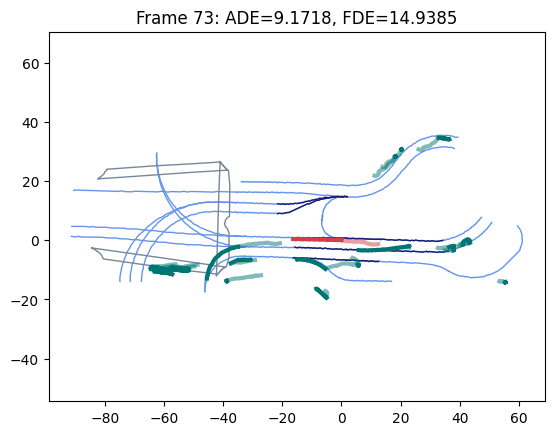

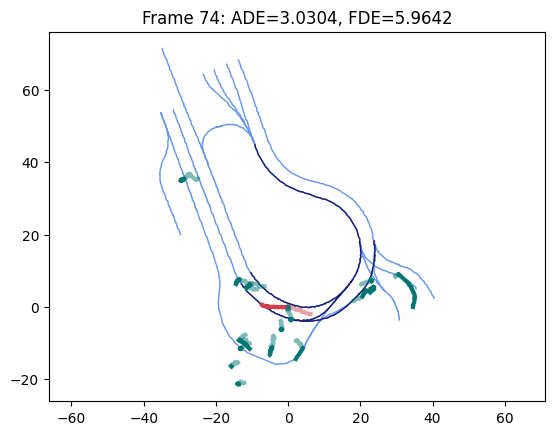

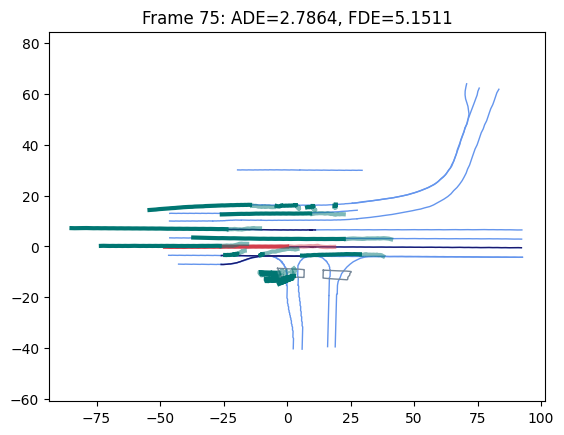

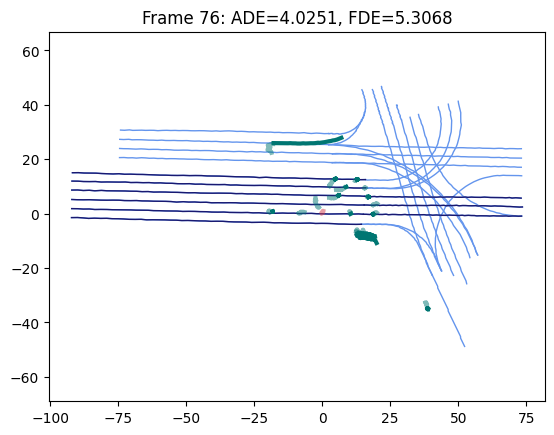

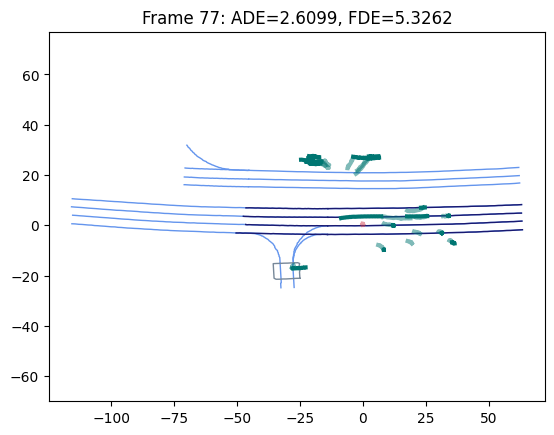

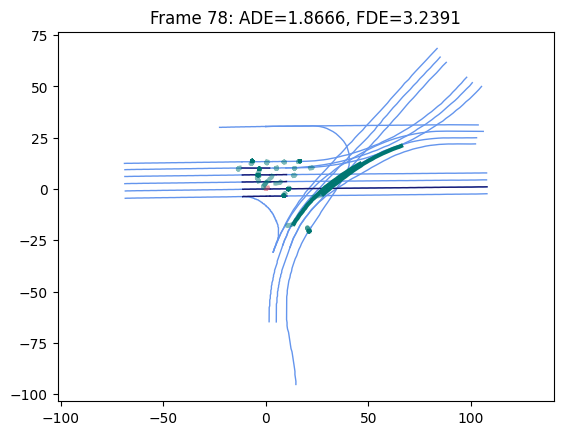

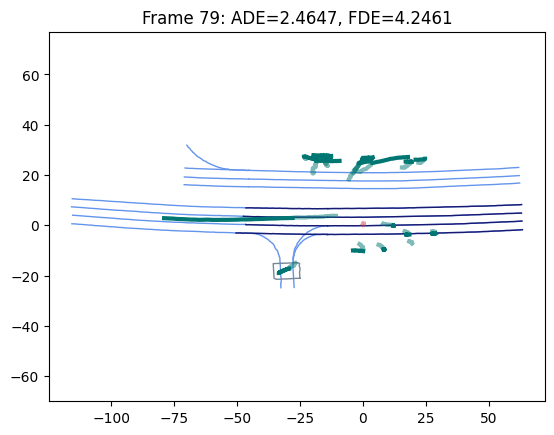

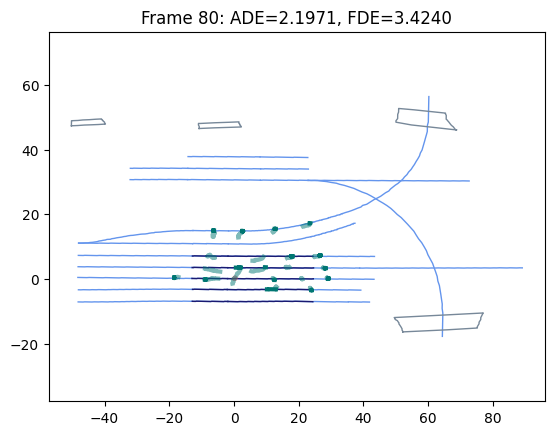

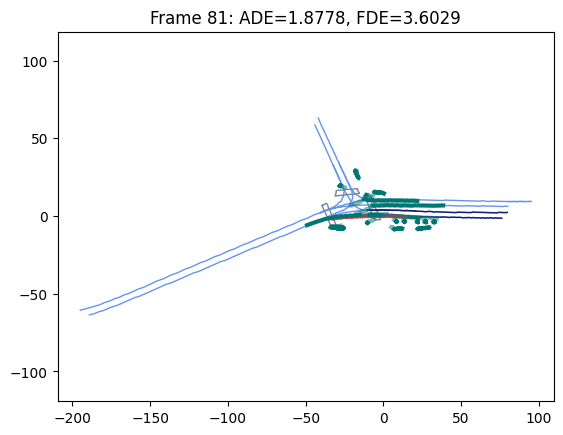

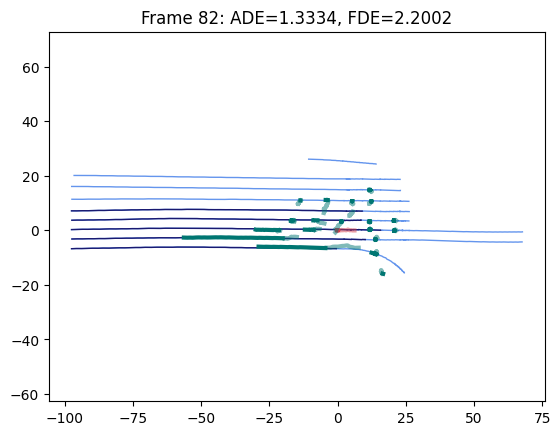

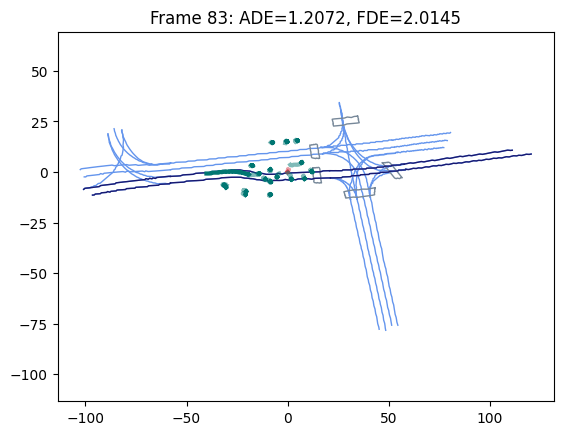

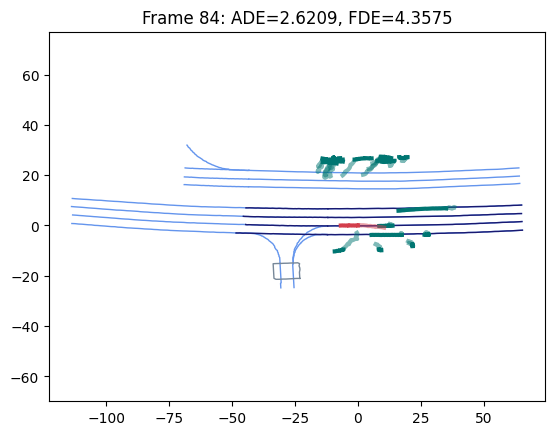

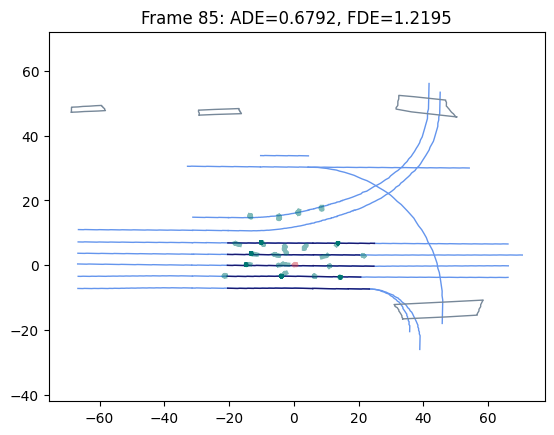

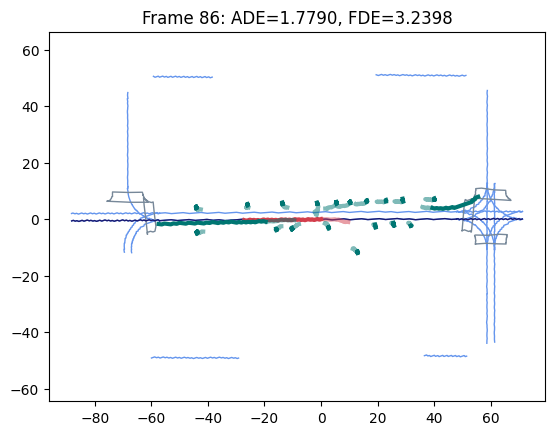

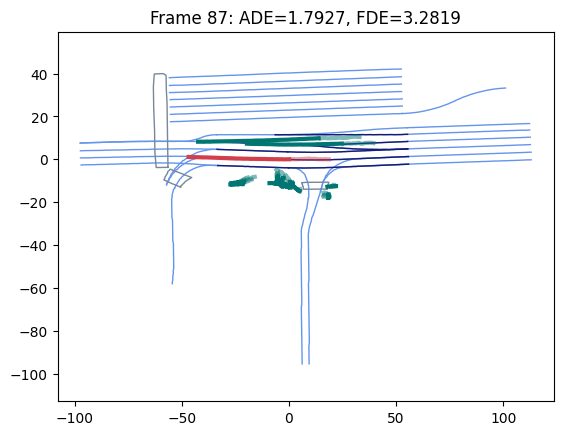

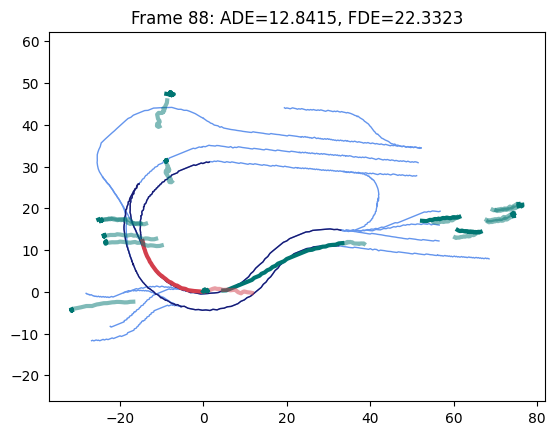

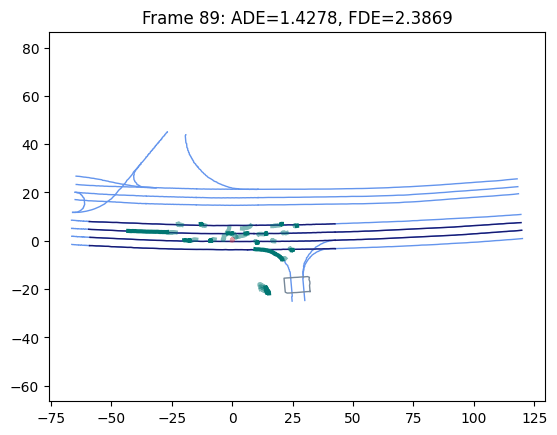

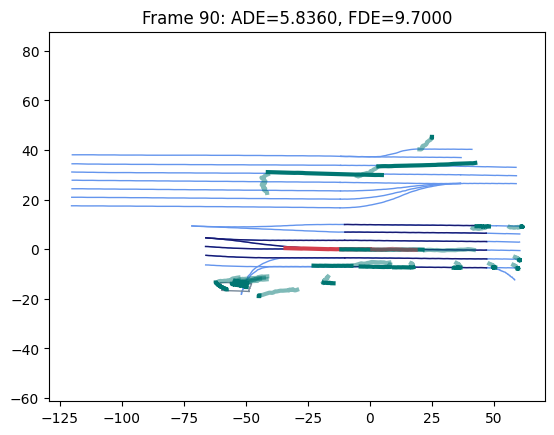

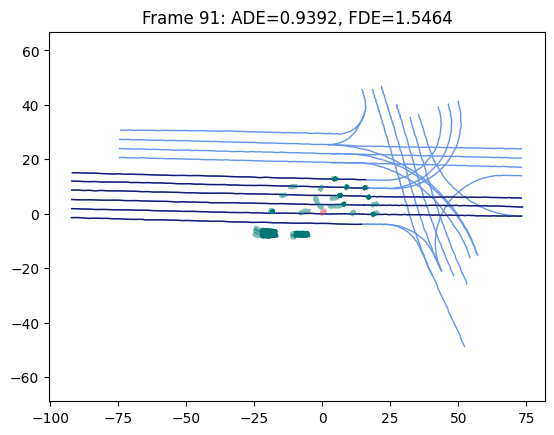

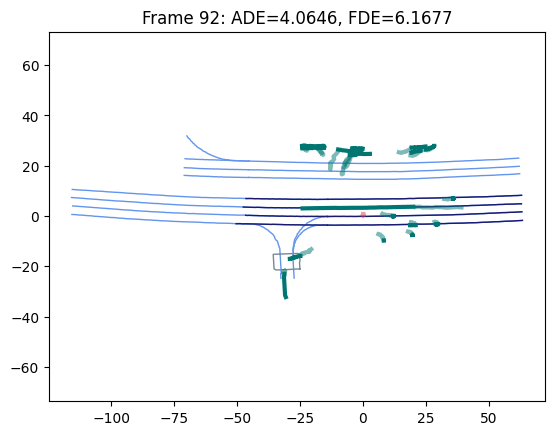

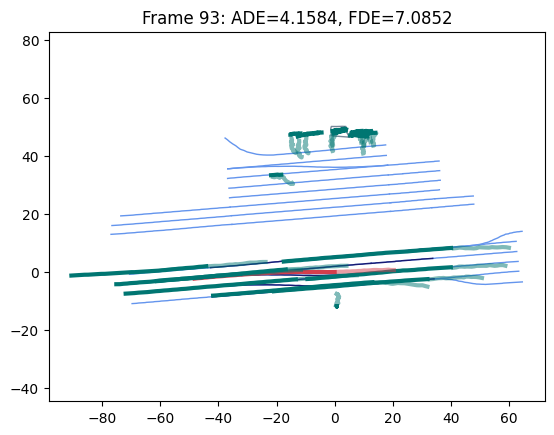

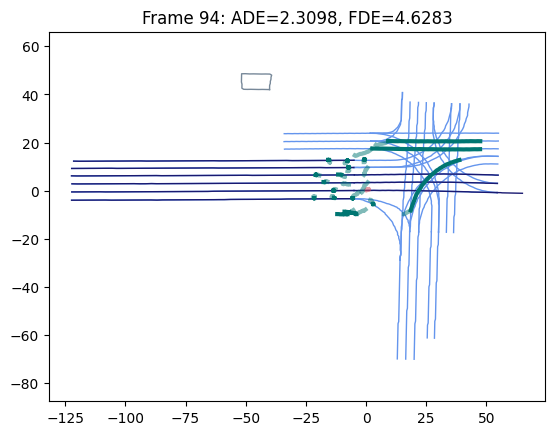

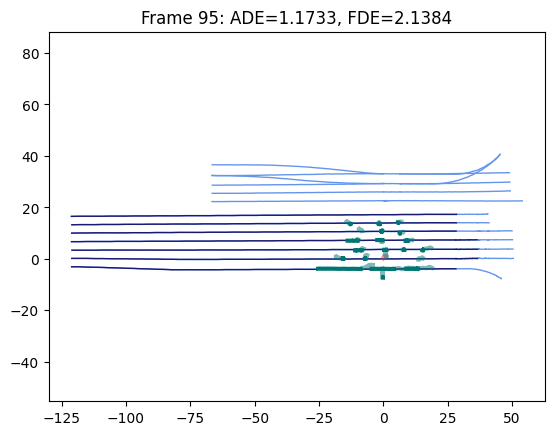

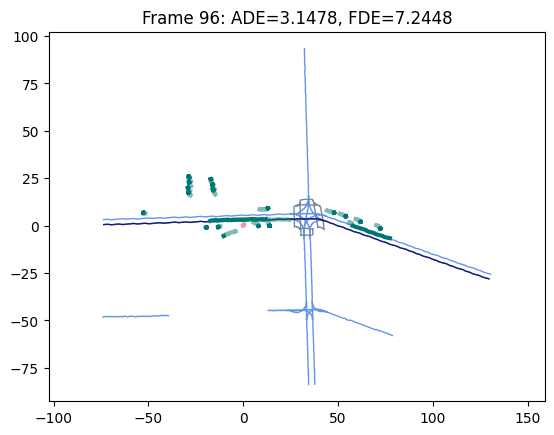

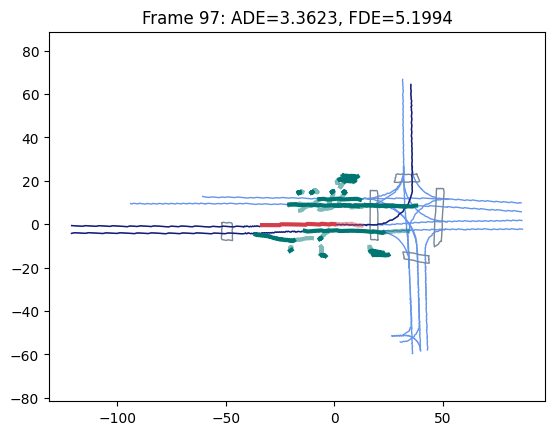

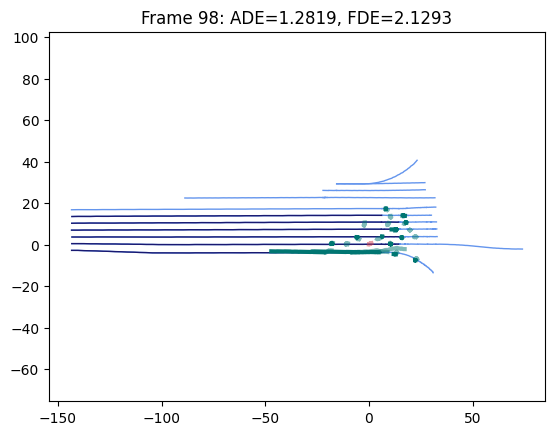

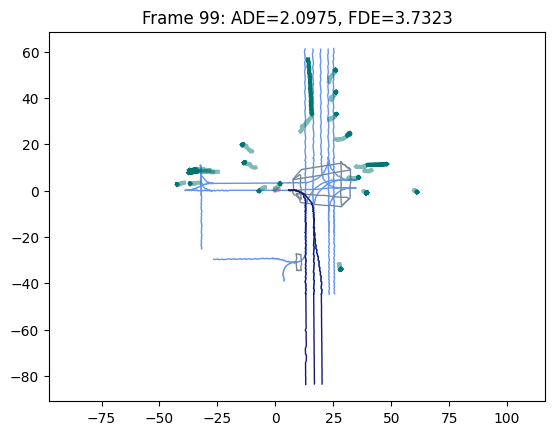

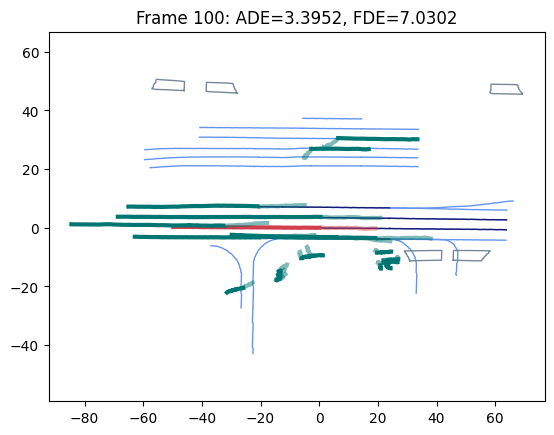

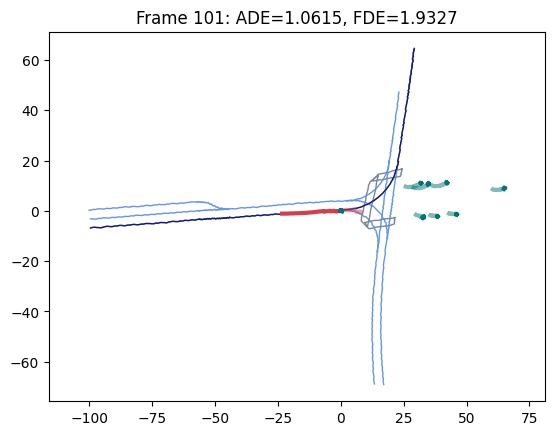

Average Displacement Error (ADE): 2.9752
Final Displacement Error (FDE): 5.1291


In [17]:
# Ensure results directory exists
if not os.path.exists('./result/'):
    os.makedirs('./result/')

model.eval()
ade_total = 0.0
fde_total = 0.0
num_samples = 0

with torch.no_grad():
    for i, data in enumerate(validate_loader):
        data = data.to(device)
        observations = data.x
        model_out = model(data)
        
        ego_past, agent_past_list, \
        lane_list, crosswalk_list, \
        route_lane_list, \
        agent_current_pose_list = decoding_features(observations)        
        predicted_path_list = increment_to_trajectories(model_out.cpu(), agent_current_pose_list)
        
        ground_truth_increment = data.y.cpu()
        ground_truth_increment = ground_truth_increment.view(config.NUM_AGENTS + 1, config.NUM_FUTURE_POSES * 2)
        ground_truth_list = increment_to_trajectories(ground_truth_increment, agent_current_pose_list)        
        
        # Calculate ADE and FDE
        ade = 0.0
        fde = 0.0
        for pred_path, gt_path in zip(predicted_path_list, ground_truth_list):
            ade += torch.mean(torch.norm(pred_path - gt_path, dim=1)).item()
            fde += torch.norm(pred_path[-1] - gt_path[-1]).item()
        
        ade /= len(predicted_path_list)
        fde /= len(predicted_path_list)
        
        ade_total += ade
        fde_total += fde
        num_samples += 1

        # 绘制轨迹和地图
        draw_trajectory(ego_past, agent_past_list)
        create_map_raster(lane_list, crosswalk_list, route_lane_list)
        draw_trajectory(predicted_path_list[0, :, :], predicted_path_list[1:, :, :], alpha=0.5, linewidth=3)
        # draw_trajectory(ground_truth_list[0, :, :], ground_truth_list[1:, :, :], alpha=0.8, linewidth=1.5)
        plt.axis('equal')
        
        # Set title with ADE and FDE
        plt.title(f"Frame {i}: ADE={ade:.4f}, FDE={fde:.4f}")
        
        file_name = 'result/output_' + str(i) + '.png'
        plt.savefig(file_name)
        plt.show()
        plt.close()

# Calculate and print final ADE and FDE
ade_total /= num_samples
fde_total /= num_samples
print(f"Average Displacement Error (ADE): {ade_total:.4f}")
print(f"Final Displacement Error (FDE): {fde_total:.4f}")